In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
import numpy as np
from graph.structure import Graph
from graph.prior.gaussian_prior import GaussianPrior
from graph.prior.support_prior import SupportPrior
from graph.measurement.amplitude_measurement import AmplitudeMeasurement
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from core.linalg_utils import circular_aperture

In [3]:
# パラメータ設定
shape = (64, 64)
support = circular_aperture(shape, radius=0.25)
rng = np.random.default_rng(42)

In [4]:
# グラフ定義
class MultiplyTestGraph(Graph):
    def __init__(self):
        super().__init__()
        X = GaussianPrior(var = 1.0, shape = shape, label="X")
        Y = GaussianPrior(var = 1.0, shape = shape, label="Y")
        Z = X * Y  # MultiplyPropagatorを介して構成される

        # 測定ノード（適当なものでOK）
        self.meas = AmplitudeMeasurement(var=1e-3) @ (FFT2DPropagator() @ Z)
        self.compile()

In [5]:
g = MultiplyTestGraph()

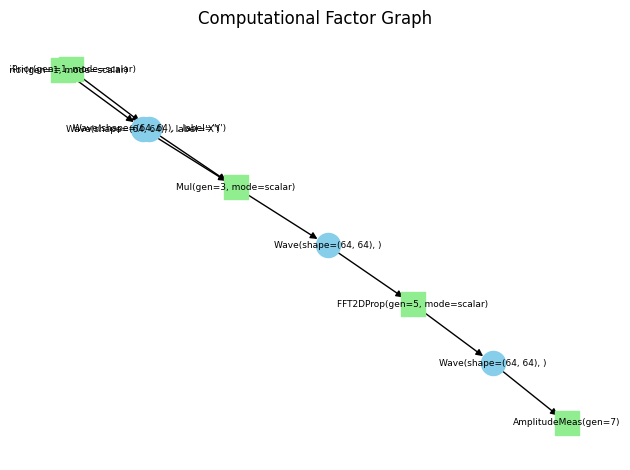

In [6]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

BP Iteration: 100%|██████████| 200/200 [00:00<00:00, 1136.47it/s]

[t=0] PMSE = 1.68437e+00
[t=20] PMSE = 1.83522e-04
[t=40] PMSE = 1.83522e-04
[t=60] PMSE = 1.83522e-04
[t=80] PMSE = 1.83522e-04
[t=100] PMSE = 1.83522e-04
[t=120] PMSE = 1.83522e-04
[t=140] PMSE = 1.83522e-04
[t=160] PMSE = 1.83522e-04
[t=180] PMSE = 1.83522e-04


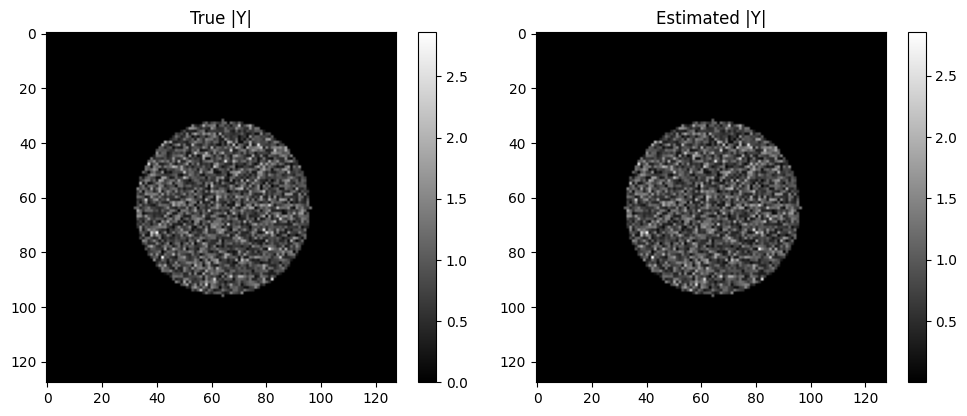

In [7]:
# ==== Imports ====
import numpy as np
import matplotlib.pyplot as plt

from core.linalg_utils import random_normal_array, circular_aperture
from core.metrics import pmse
from graph.structure.graph import Graph
from graph.prior.const_wave import ConstWave
from graph.prior.support_prior import SupportPrior
from graph.measurement.gaussian_measurement import GaussianMeasurement
from graph.propagator.multiply_propagator import MultiplyPropagator

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
large_value = 1e6
rng = np.random.default_rng(42)

# Known input X
x_ref = random_normal_array(shape, dtype=np.complex128, rng=rng)

# Support for unknown Y
support = circular_aperture(shape, radius=0.25)

# ==== 2. グラフ定義 ====
class MultiplyGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = ConstWave(data=x_ref, large_value=large_value, label="X_ref")
        self.Y = SupportPrior(support=support, label="Y_unknown")
        self.Z = self.X * self.Y  # MultiplyPropagator via __mul__
        self.meas = GaussianMeasurement(var=var) @ self.Z
        self.compile()

# ==== 3. 初期化と推論 ====
g = MultiplyGraph()
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=123), update_observed=True)

true_y = g.get_wave("Y_unknown").get_sample()

def monitor(graph, t):
    est = graph.get_wave("Y_unknown").compute_belief().data
    err = pmse(est, true_y)
    if t % 20 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=200, callback=monitor)

# ==== 4. 可視化 ====
est = g.get_wave("Y_unknown").compute_belief().data

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("True |Y|")
plt.imshow(np.abs(true_y), cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Estimated |Y|")
plt.imshow(np.abs(est), cmap='gray')
plt.colorbar()

plt.tight_layout()
plt.show()